In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.wcs import wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils import EPSFBuilder
from photutils.psf import DAOGroup
from photutils.background import MADStdBackgroundRMS, MMMBackground
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import BasicPSFPhotometry
from astropy.visualization import simple_norm
import time
from photutils import CircularAperture
from photutils import aperture_photometry

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


#### Load the file that contains three consecutive images

In [2]:
files = 'm35FitFileFluxChange.txt'

In [3]:
filelist = np.loadtxt(files,dtype=str)

#### Set the center and size of the region that will be looked at

In [4]:
coord = SkyCoord(ra=92.3201875, dec= 24.30348139, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.5, u.deg)
height = u.Quantity(0.5, u.deg)

#### Use the Gaia catalog to find the positions of potential stars to be used when making the PSF model

In [5]:
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

Query finished.


In [6]:
ra = r['ra']
dec = r['dec']
flux = r['phot_rp_mean_flux']
mag = r['phot_rp_mean_mag']

#### Reject stars that are too bright or too faint

In [7]:
brightstars = np.where((mag<15) & (mag>10))

In [8]:
flux = flux[brightstars]
mag = mag[brightstars]
brightstars_length = mag.size

#### We also want stars that are somewhat isolated, so we take out the stars that are too close to another star

In [9]:
goodstars = np.zeros(brightstars_length)
for i in np.arange(brightstars_length):
#for i in np.arange(20):
    rastar1 = ra[brightstars[0][i]]
    decstar1 = dec[brightstars[0][i]]
    closestars = np.where(np.sqrt((dec - decstar1)**2 + ((ra - rastar1)*15*(np.cos(decstar1*np.pi/180.0)))**2)<0.005)
    if len(closestars[0]) >1:
        goodstars[i] = -1

In [10]:
starstouse = np.where(goodstars==0)

In [11]:
ra = ra[brightstars]
dec = dec[brightstars]
ra = ra[starstouse]
dec = dec[starstouse]
flux = flux[starstouse]

#### Circle all the stars that we use in the model

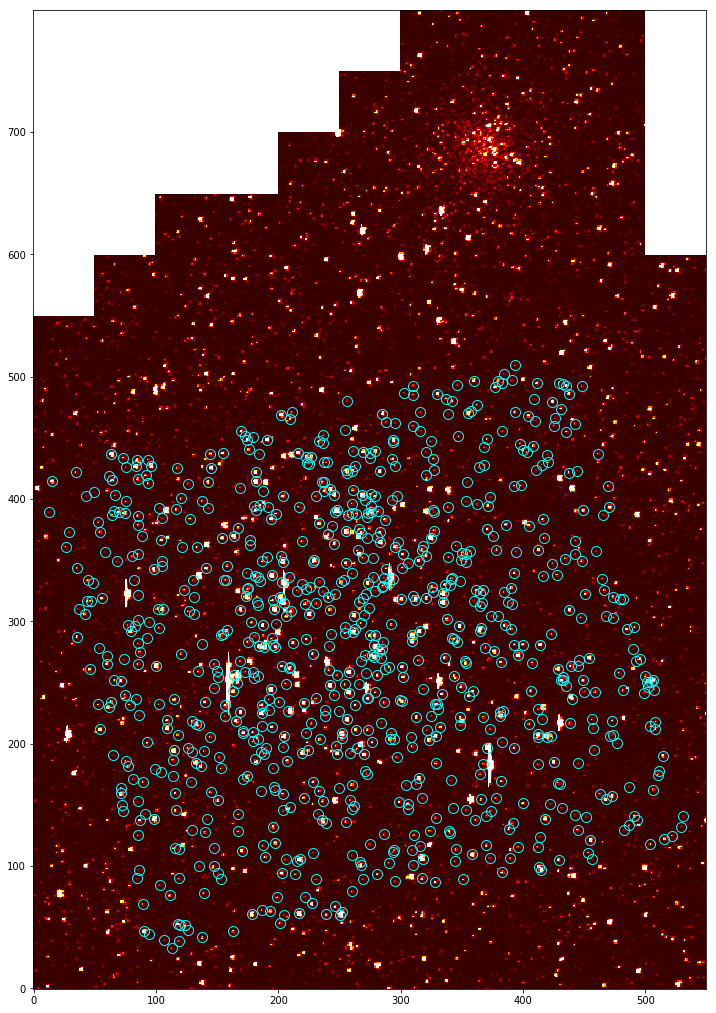

In [12]:
image = fits.getdata(filelist[0])
header = fits.getheader(filelist[0])
wcs_transform = wcs.WCS(header)
c = wcs_transform.wcs_world2pix(np.asarray([ra,dec]).T, 0)
plt.figure(figsize=(24, 18))
plt.imshow(image, cmap='hot', vmin = -100, vmax = 10000, interpolation='None', origin='lower')
plt.plot(c.T[0], c.T[1], marker="o", markersize = 10, markerfacecolor='None', markeredgecolor='cyan', linestyle='None')

#### The right ascension and declination of the star we are looking at 

In [13]:
star1ra = 92.126041
star1dec = 24.441154

#### Loop through the three images and perform photometry

68.55283212661743
66.37926411628723
68.74833106994629


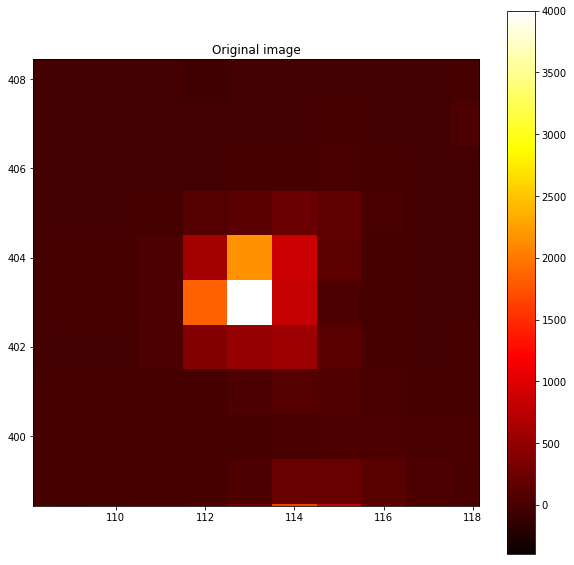

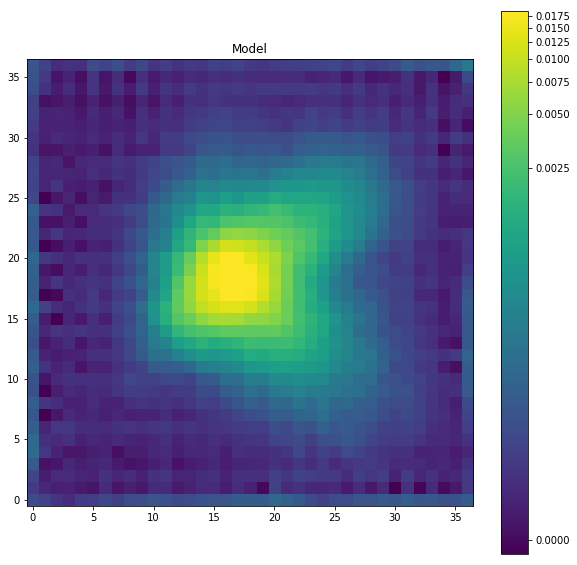

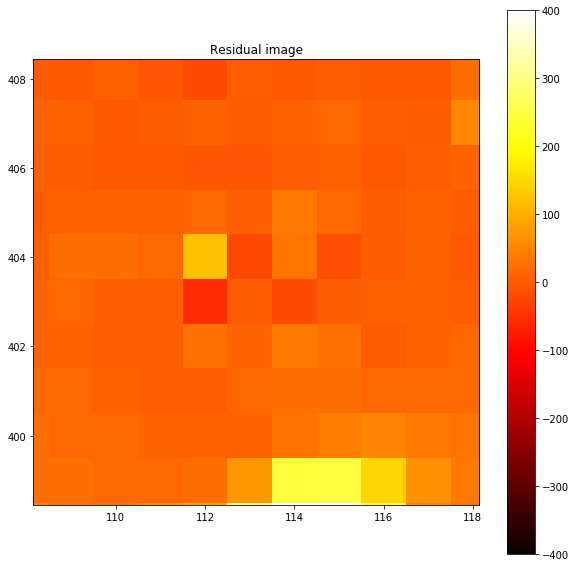

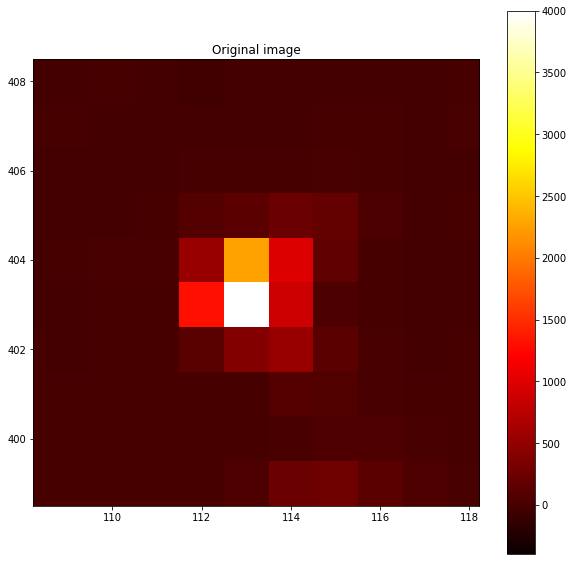

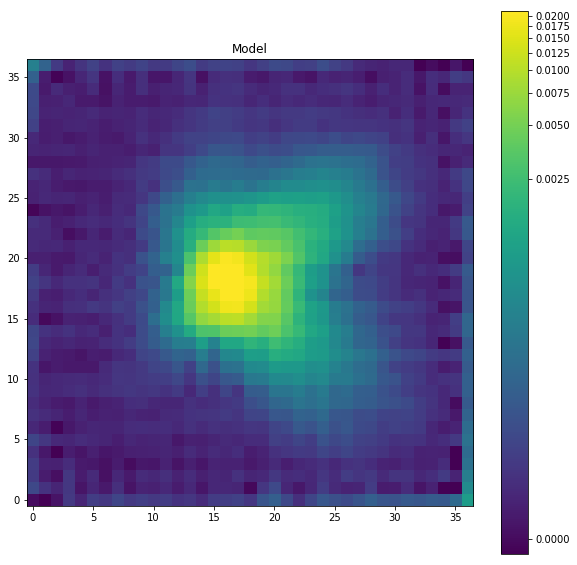

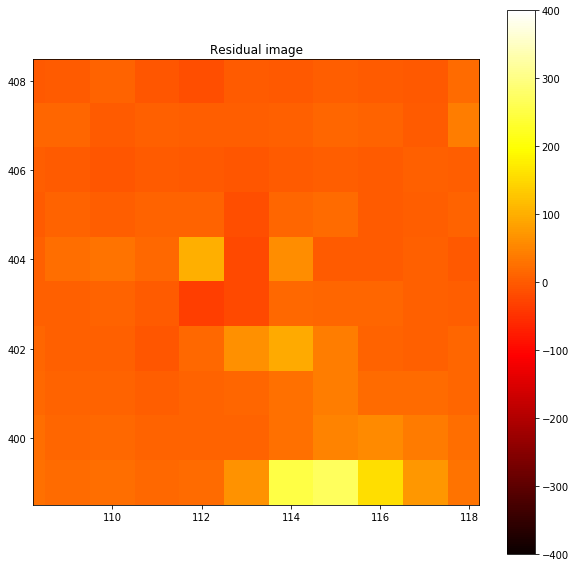

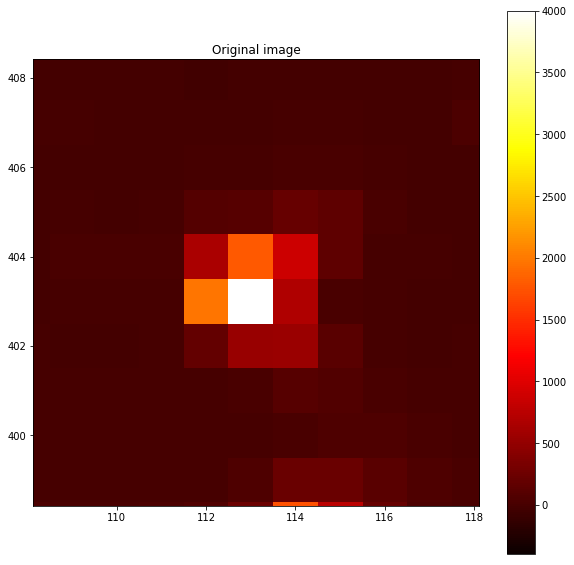

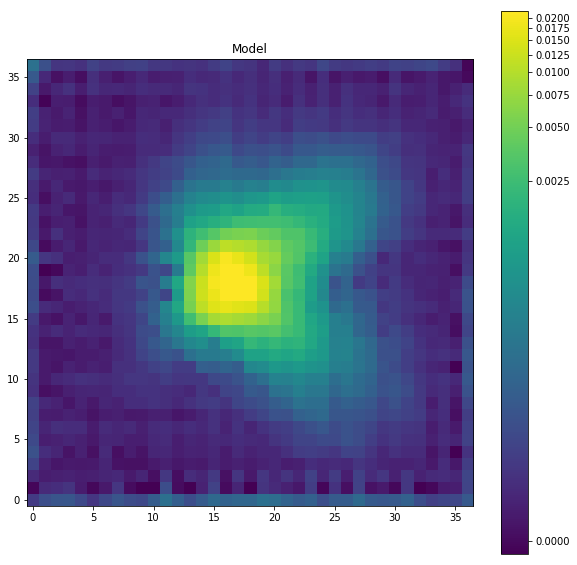

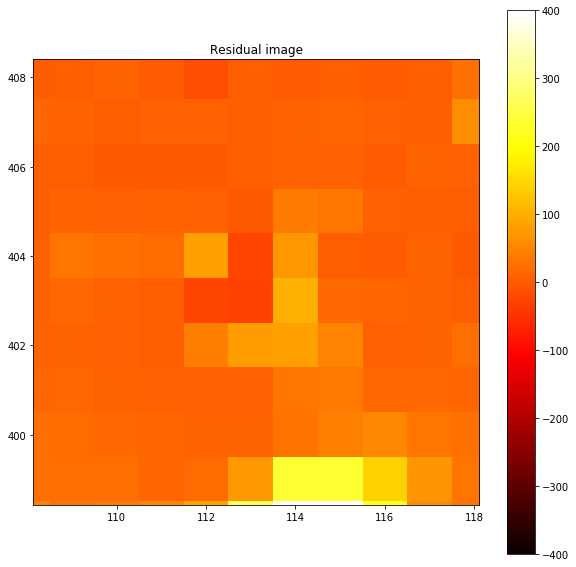

In [15]:
counter =0
times = np.array([])
fluxes= np.array([])
aperture_fluxes = np.array([])
residual_fluxes = np.array([])
uncertainties = np.array([])
oversample = 4

while counter<3:
    start = time.time()
    file = filelist[counter]
    data = fits.getdata(file)
    header = fits.getheader(file)
    times = np.append(times, header['MIDTIME']) 
    
    wcs_transform = wcs.WCS(header)
    xstar1, ystar1 = wcs_transform.wcs_world2pix([[star1ra, star1dec]], 0)[0]
    coords = wcs_transform.wcs_world2pix(np.asarray([ra,dec]).T, 0)
    stars_tbl = Table()
    stars_tbl['x'] = coords.T[0]
    stars_tbl['y'] = coords.T[1]
    
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 2.)
    data -= median_val
    nddata = NDData(data = data)
    stars = extract_stars(nddata, stars_tbl, size = 9)
    epsf_builder = EPSFBuilder(oversampling =oversample, recentering_boxsize = 1, recentering_maxiters = 1,maxiters =10, progress_bar = False)
    epsf, fitted_stars = epsf_builder(stars)
 
    #plot the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='hot', vmin = -400, vmax = 4000, interpolation='None', origin='lower')
    plt.xlim(xstar1 - 5, xstar1+5)
    plt.ylim(ystar1 - 5,ystar1+5)
    plt.colorbar()
    plt.title('Original image')

    norm = simple_norm(epsf.data, 'log', percent = 99.)
    
    #plot the models
    plt.figure(figsize=(10, 10))
    plt.imshow(epsf.data, norm = norm, origin = 'lower', cmap = 'viridis')
    plt.colorbar()
    plt.title('Model')
    
    bkgrms = MADStdBackgroundRMS()
    std = bkgrms(data)
    daogroup = DAOGroup(2.0*0.5*gaussian_sigma_to_fwhm)
    
    epsf.normalization_correction = 1.0/(oversample**2)
    
    psf_model = epsf
    mmm_bkg = MMMBackground()
    fitter = LevMarLSQFitter()
   
    epsf.x_0.fixed = False
    epsf.y_0.fixed = False
    posStar1 = Table(names = ['x_0', 'y_0'], data = [[xstar1], [ystar1]])
    
    photometry = BasicPSFPhotometry(group_maker = daogroup, bkg_estimator = mmm_bkg, psf_model = psf_model, 
                               fitter = fitter, fitshape = (7, 7), aperture_radius = 3)
    result_tab_star1 = photometry(image = data, init_guesses = posStar1)
    residual_image_star1 = photometry.get_residual_image()
    fluxes = np.append(fluxes, result_tab_star1['flux_fit'])
    uncertainties = np.append(uncertainties, result_tab_star1['flux_unc'])

    #perform aperture photometry on the residuals to account for what the model missed
    position = [( result_tab_star1['x_fit']), ( result_tab_star1['y_fit'])]
    aperture = CircularAperture(position, r = 3.)
    phot_table = aperture_photometry(data, aperture)
    aperture_fluxes = np.append(aperture_fluxes, phot_table['aperture_sum'])
    residual_phot_table = aperture_photometry(residual_image_star1, aperture)
    residual_fluxes = np.append(residual_fluxes, residual_phot_table['aperture_sum'])
     
    #plot the residual images
    plt.figure(figsize=(10, 10))
    plt.imshow(residual_image_star1, cmap='hot', vmin = -400, vmax = 400, interpolation='None', origin='lower')
    plt.xlim(xstar1 - 5, xstar1+5)
    plt.ylim(ystar1 - 5,ystar1+5)
    plt.colorbar()
    plt.title('Residual image')
    
    #see how long each iteration takes
    end = time.time()
    print(end - start)
    counter = counter+1

## Now explore the outputs

#### PSF fluxes and uncertainties

In [16]:
fluxes

array([14990.66865476, 15321.56023808, 14503.32077739])

In [17]:
uncertainties

array([ 72.92351693,  79.79109903, 100.12589185])

#### Residual fluxes within a three pixel aperture

In [18]:
residual_fluxes

array([341.23992387, 497.13932346, 680.71818744])

#### Aperture fluxes using a three pixel aperture

In [19]:
aperture_fluxes

array([14172.91563434, 14235.30087394, 14272.36795401])